In [60]:
import numpy as np
import torch
import torch.nn as nn
from spikingjelly.activation_based import neuron, encoding, learning, functional
from utils.image_processing import processSingleImage
import matplotlib.pyplot as plt
from utils.plasticity import STDPLearner
import cv2

In [61]:
def f_weight(x):
    return torch.clamp(x,-1,1)

In [62]:
class VPR(nn.Module):
    def __init__(self, tau, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)

        self.layer = nn.Sequential(
            nn.Flatten(),
            nn.Linear(28 * 28, 2, bias=False),
            neuron.LIFNode(tau=2., v_threshold=0.6)
        )

    def forward(self, x: torch.Tensor) -> nn.Sequential:
        return self.layer(x)

In [63]:
imagePath = "/media/geoffroy/T7/VPRSNN/data/nordland/fall/images-00001.png"
reference_img = cv2.imread(imagePath)
img = processSingleImage(imagePath, 28, 28, 7)
img = np.expand_dims(img, axis=0)
img = torch.from_numpy(img)

In [64]:
torch.manual_seed(0)


w_min, w_max = -1, 1
tau_pre = 2.
tau_post = 2.
T = 128
N = 2
learning_rate = 0.02
net = VPR(tau=0.2)
optimizer = torch.optim.SGD(net.layer.parameters(), lr=learning_rate, momentum=0.)
encoder = encoding.PoissonEncoder()

nn.init.constant_(net.layer[1].weight.data, 0.4)

stdp_learner = learning.STDPLearner(step_mode='s', synapse=net.layer[1], sn=net.layer[2], tau_pre=tau_pre, tau_post=tau_post, f_pre=f_weight, f_post=f_weight)
functional.set_step_mode(net, 's')

In [65]:
in_spike = []
out_spike = []
trace_pre = []
trace_post = []
weight = []

for t in range(T):
    encoded_img = encoder(img)
    out_spike.append(net(encoded_img.float()))
    stdp_learner.step(on_grad=True)
    in_spike.append(encoded_img)
    weight.append(net.layer[1].weight.data.clone())
    trace_pre.append(stdp_learner.trace_pre)
    trace_post.append(stdp_learner.trace_post)
print(out_spike[0][0].detach().numpy())

[1. 1.]


ValueError: operands could not be broadcast together with shapes (128,) (2,) 

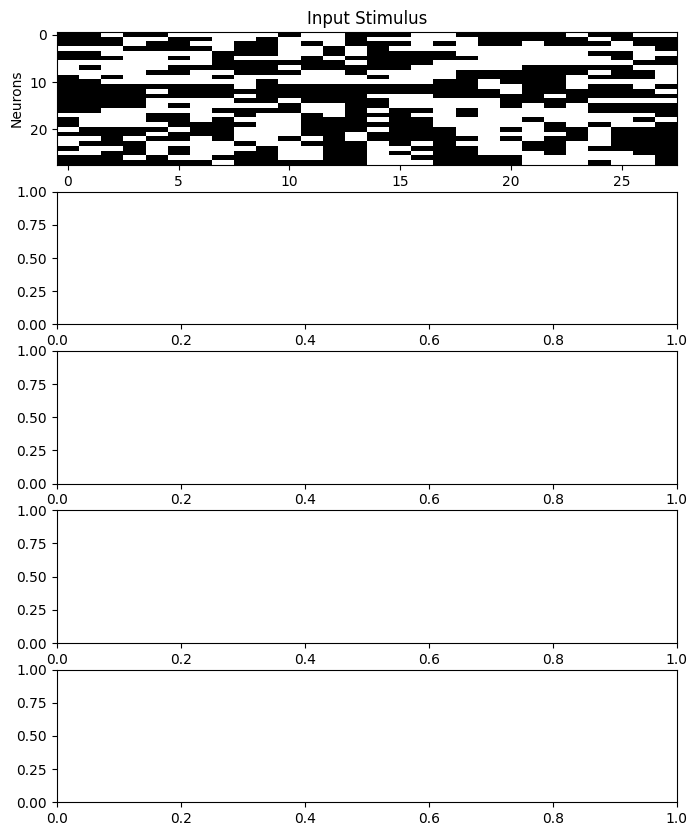

In [69]:
t = np.arange(T)

# creating subplots for plotting
fig, axes = plt.subplots(5, 1, figsize=(8, 10))

# plotting the input stimulus
axes[0].imshow(encoded_img.squeeze(), cmap='gray', aspect='auto')
axes[0].set_title('Input Stimulus')
axes[0].set_xlabel('Time Steps')
axes[0].set_ylabel('Neurons')

# plotting the output spikes
axes[1].eventplot(t * out_spike[0].squeeze().detach().numpy())
axes[1].imshow(torch.stack(out_spike).squeeze().detach().numpy(), cmap='gray', aspect='auto', vmin=0, vmax=1)
axes[1].set_title('Output Spikes')
axes[1].set_xlabel('Time Steps')
axes[1].set_ylabel('Neurons')

# plotting the pre-synaptic trace
axes[2].plot((trace_pre[0]).squeeze().detach().numpy().T)
axes[2].set_title('Pre-synaptic Trace')
axes[2].set_xlabel('Time Steps')
axes[2].set_ylabel('Neurons')

# plotting the post-synaptic trace
axes[3].plot(torch.stack(trace_post).squeeze().detach().numpy().T)
axes[3].set_title('Post-synaptic Trace')
axes[3].set_xlabel('Time Steps')
axes[3].set_ylabel('Neurons')

# plotting the weight
w = weight[0][0].numpy()
axes[4].plot(w)

plt.tight_layout()
plt.show()